# Running Charged Defect Calculation

The Formation Energy of a charged defect is given by the 

$E^f[X^q] = {\color{#ff6d00}{E_{\text{tot}}[X^q]}} - E_{\text{tot}}[\text{bulk}] + \sum_i n_i\mu_i + qE_{\text{F}} + \color{#ff6d00}{\Delta^q},$

## Description of Terms

### Directly Obtained from Supercell DFT Calculations

- **$E^f[X^q]$**: Formation energy of defect $X$ in charge state $q$

- **${\color{#ff6d00}{E_{\text{tot}}[X^q]}}$**: Total energy of the supercell containing defect $X$ with charge $q$

- **$E_{\text{tot}}[\text{bulk}]$**: Total energy of the perfect bulk supercell (reference state)

- **$\color{#ff6d00}{\Delta^q}$**: Correction term for charged systems, including potential alignment and finite-size corrections

### External information required

- **$\sum_i n_i\mu_i$**: Sum of the chemical potentials of atoms added ($n_i > 0$) or removed ($n_i < 0$). Needs the MP phase diagram for competing phases.

- **$qE_{\text{F}}$**: Energy contribution adding/removing electron, where $E_{\text{F}}$ is the Fermi level. Needs a high quality band structure calculation of the bulk material.

The <span style="color:#ff6d00">orange-colored</span> terms highlight the terms that are directly obtained from the explicit charged supercell calculations. These terms are the main focus of the automated defect workflow in `atomate2` since these are the terms that are unique for each charge state. Their contributions are combined in the 

This notebook will guide you through how to obtain all of these terms using DFT calculations and the Materials Project database.


In [17]:
# First make sure that the defect analysis add-on is installed
# If the defect package is not installed, uncomment the following line
# !pip install pymatgen-analysis-defects;

In [18]:
import itertools

from monty.serialization import dumpfn, loadfn
from pymatgen.analysis.defects.generators import (
    ChargeInterstitialGenerator,
    SubstitutionGenerator,
    VacancyGenerator,
)
from pymatgen.analysis.defects.plotting.thermo import plot_formation_energy_diagrams
from pymatgen.analysis.defects.supercells import get_sc_fromstruct
from pymatgen.core import Structure, _load_pmg_settings
from pymatgen.ext.matproj import MPRester
from pymatgen.io.vasp import Chgcar
from pymatgen.io.vasp.sets import MPScanRelaxSet

from atomate2.vasp.flows.defect import FormationEnergyMaker
from atomate2.vasp.flows.mp import MPMetaGGADoubleRelaxMaker, MPMetaGGARelaxMaker
from atomate2.vasp.powerups import (
    update_user_incar_settings,
    update_user_kpoints_settings,
)
from atomate2.vasp.sets.defect import SPECIAL_KPOINT

PMG_SETTINGS = _load_pmg_settings()
PMG_MAPI_KEY = PMG_SETTINGS.get("PMG_MAPI_KEY", None)

## Generate the Defect Objects from MP Charge Density

The vacancies and substitutional defects can be generated from the structure alone.

But interstitial are best generated using the electronic charge density.

We can download the charge density from the Materials Project and use it to generate all of the native point defects.

In [19]:
# Make sure that you have the full featured API installed
# via `pip install mp-api`
if PMG_MAPI_KEY:
    mpr = MPRester()  # or add your own API key as an argument here
    chgcar = mpr.get_charge_density_from_material_id("mp-804")
else:
    chgcar = Chgcar.from_file("./data_files/GaN-chgcar.vasp")

You can enumerate over different speices involved in the
vacancy, interstitial and substitutions using the helper functions
below.

In [20]:
def _get_elements(struct: Structure) -> tuple[tuple[str], ...]:
    """Get the elements involved in the structures."""
    s_atoms = sorted(atom.symbol for atom in struct.elements)
    return tuple((aa_,) for aa_ in s_atoms)


def _get_subs(struct: Structure) -> tuple[dict[str, str], ...]:
    """Get native substitutions."""
    s_atoms = sorted(atom.symbol for atom in struct.elements)
    return tuple(
        itertools.chain.from_iterable(
            ({a: b}, {b: a}) for a, b in itertools.combinations(s_atoms, 2)
        )
    )


print(_get_elements(chgcar.structure))  # noqa: T201
print(_get_subs(chgcar.structure))  # noqa: T201

(('Ga',), ('N',))
({'Ga': 'N'}, {'N': 'Ga'})


The different defect generators are available in the `pymatgen.analysis.defects` module each with their own set of tolerances parameters.

Once those are configured,

In [21]:
VGEN = VacancyGenerator(symprec=0.01)
IGEN = ChargeInterstitialGenerator(max_insertions=3)
SGEN = SubstitutionGenerator(angle_tolerance=5)

In [22]:
def get_defects(chgcar: Chgcar, max_iter: int = 3):  # noqa: ANN201
    """Generate the defects for a chgcar.

    Args:
        chgcar: The chgcar object.
        max_iter: The maximum number of defects of each type to generate.

    Returns
    -------
        A generator of (defect, index) pairs.
    """
    tup_el = _get_elements(chgcar.structure)
    tup_sub = _get_subs(chgcar.structure)
    for sub_d in tup_sub:
        for ii, defect in enumerate(SGEN.generate(chgcar.structure, sub_d)):
            if ii < max_iter:
                yield defect, ii

    for el in tup_el:
        for ii, defect in enumerate(VGEN.generate(chgcar.structure, el)):
            if ii < max_iter:
                yield defect, ii

    for el in tup_el:
        for ii, defect in enumerate(
            IGEN.generate(
                chgcar,
                el,
            )
        ):
            if ii < max_iter:
                yield defect, ii

In [23]:
for defect, defect_index in get_defects(chgcar):
    print(defect, defect_index)  # noqa: T201

N subsitituted on the Ga site at at site #0 0
Ga subsitituted on the N site at at site #2 0
Ga Vacancy defect at site #0 0
N Vacancy defect at site #2 0
Ga intersitial site at [0.00,0.00,0.20] 0
Ga intersitial site at [0.35,0.65,0.69] 1
N intersitial site at [0.00,0.00,0.20] 0
N intersitial site at [0.35,0.65,0.69] 1


These generators find 8 symmetry distinct defects in the structure.
2 vacancies, 2 substitutions, and 4 interstitials.


In [24]:
DEFECT_RELAX_SC = MPMetaGGARelaxMaker(
    input_set_generator=MPScanRelaxSet(
        use_structure_charge=True, user_incar_settings={"ISIF": 2}
    ),
    task_document_kwargs={"store_volumetric_data": ["locpot"]},
)
BULK_RELAX_SC = MPMetaGGADoubleRelaxMaker()

maker = FormationEnergyMaker(
    bulk_relax_maker=BULK_RELAX_SC,
    defect_relax_maker=DEFECT_RELAX_SC,
    collect_defect_entry_data=True,
)

In [25]:
maker = update_user_kpoints_settings(maker, kpoints_updates=SPECIAL_KPOINT)

maker = update_user_incar_settings(maker, incar_updates={"ENCUT": 400, "NCORE": 4})

In [26]:
sc_mat = get_sc_fromstruct(chgcar.structure, min_atoms=40, max_atoms=64, min_length=2)
sc_mat

array([[ 3,  3,  0],
       [-1,  1,  0],
       [ 0,  0,  2]])

In [27]:
# Uncomment this to true if you have jobflow remote configured
# and want to actually run this
RUN_FOR_REAL = False

if RUN_FOR_REAL:
    from jobflow_remote import submit_flow

    for defect, defect_index in get_defects(chgcar):
        defect.user_charges = [-1, 0, 1]
        flow = maker.make(defect, defect_index=defect_index, supercell_matrix=sc_mat)
        submit_flow(flow, worker="cpu", project="a2_tut")

Wait a couple of hours for the calculations to finish.


In [33]:
if RUN_FOR_REAL:
    from jobflow_remote import get_jobstore

    with get_jobstore("a2_tut") as js:
        # store the defect entries
        defect_entries = []
        for de_doc in js.query({"name": "get_defect_entry"}):
            defect_entries.append(  # noqa: PERF401
                [d_["defect_entry"] for d_ in de_doc["output"]]
            )
        dumpfn(defect_entries, "./data_files/defects/all_defect_entries.json")

        # store the bulk task: only for the band gap
        bulk_task_doc = js.query_one({"name": "MP meta-GGA relax 2"})
        bulk_task_output = bulk_task_doc["output"]["calcs_reversed"][0]["output"]
        dumpfn(bulk_task_output, "./data_files/defects/bulk_task_output.json")
defect_entries = loadfn("./data_files/defects/all_defect_entries.json")
bulk_task_output = loadfn("./data_files/defects/bulk_task_output.json")


In [35]:
e_vbm, e_cbm = bulk_task_output["vbm"], bulk_task_output["cbm"]

In [36]:
if PMG_MAPI_KEY:
    phase_diagram_metagga = mpr.materials.thermo.get_phase_diagram_from_chemsys(
        "Ga-N", thermo_type="R2SCAN"
    )
else:
    phase_diagram_metagga = loadfn(
        "./data_files/defects/gan_phase_diagram_metagga.json"
    )

In [40]:
from pymatgen.analysis.defects.thermo import FormationEnergyDiagram

formation_energies_diagrams = []
for de_group in defect_entries:
    formation_energies_diagrams.append(
        FormationEnergyDiagram(
            defect_entries=de_group,
            pd_entries=phase_diagram_metagga.stable_entries,
            vbm=e_vbm,
            band_gap=e_cbm - e_vbm,
        )
    )
    

/anfhome/v-jimshen/.conda/envs/af/lib/python3.12/site-packages/pymatgen/core/structure.py:2855: UserWarning:

Structure charge (1.0) is set to be not equal to the sum of oxidation states (0). Use Structure.unset_charge() to reset the charge to None.



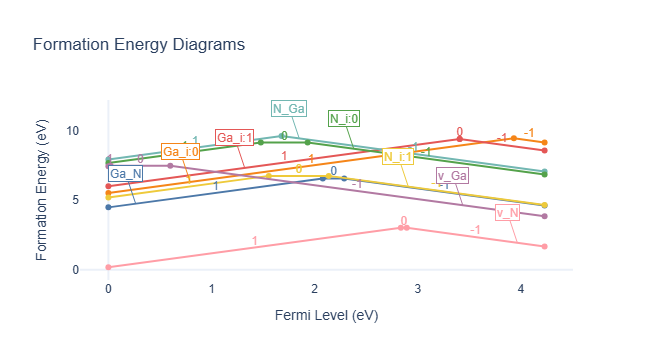

In [41]:
fed = formation_energies_diagrams[0]
chempot = fed.get_chempots(rich_element="Ga")
plot_formation_energy_diagrams(formation_energies_diagrams, chempot=chempot)

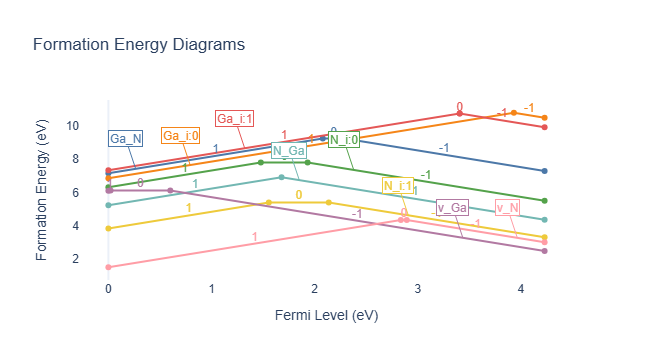

In [42]:
chempot = fed.get_chempots(rich_element="N")
plot_formation_energy_diagrams(formation_energies_diagrams, chempot=chempot)